<a href="https://colab.research.google.com/github/L4ncelot1024/Learn_Deep_Learning_Le_Wagon/blob/main/Day5/Project_A_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation


In this project, you will work on an image segmentation task. This notebook presents you the dataset to use and introduces you to one popular model - <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a> - which performs quite well for you to get a good baseline. Then we encourage you to try to improve this model and compare it to other.

NB: We recommend to not train your models for too long to have enough time to experiment with different approaches - here we focus more on the models understandings than its performances..

## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-tdhty0fd
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-tdhty0fd
  Created wheel for tensorflow-examples: filename=tensorflow_examples-f4909dfa93d6a552193d7ab19a0b3630d0402ab6_-cp37-none-any.whl size=265341 sha256=584e8cf2adcc5fbe43cf824b71261217dbe239e74382fe8ec1bd31a2b3777c9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ncmy89m8/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3+.

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6KADN5/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6KADN5/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Checking the data

The dataset downloaded is a dictionary containing both the test and the train data as PrefetchDataset object (read here about [**prefetching**](https://www.tensorflow.org/guide/data_performance#prefetching) ). We provide you an helper function to display the input data

In [ ]:
train_iterator = dataset['train'].as_numpy_iterator()
sample_data = train_iterator.next()

In [ ]:
print(sample_data.keys())

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

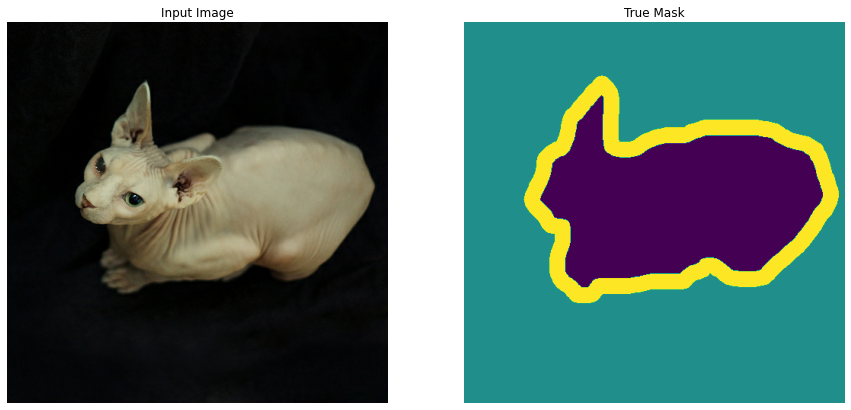

In [ ]:
display([sample_data['image'], sample_data['segmentation_mask']])

We provide you then with a basic snippet of code to load these datasets efficiently. 

This code will simply load the image and normalized it to [0,1]. You might consider updating this part to include data augmentation. For this, you can do it manually on both the image and the mask, or you can use [ReplayCompose](https://albumentations.ai/docs/examples/replay/) from the library albumentations to define a transformation and reuse it on the mask to have the exact same one applied on each tuple (image, mask). 

Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}. 


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## Define the model

The baseline model introduced here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. 
Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [ ]:
OUTPUT_CHANNELS = 3

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Look at the summary of the model
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# For this baseline, we decided to use the following layers to extract feature 
# from different scales (as described in the U-net model)
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [ ]:
# symmetrically, we need to use the same number and shape of layer for the decoder
# part
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
# Here we wrap everything in a model

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

Now, all that is left to do is to compile and train the model. For this, you will need to pick the loss which fits your problem and select relevant metrics when compiling the model so you can efficiently tracks its convergence

<details>
<summary markdown='span'>Hints
</summary>
The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.
</details>

<details>
<summary markdown='span'>View solution
</summary>

```python
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
```
</details>         

Have a quick look at the resulting model architecture:

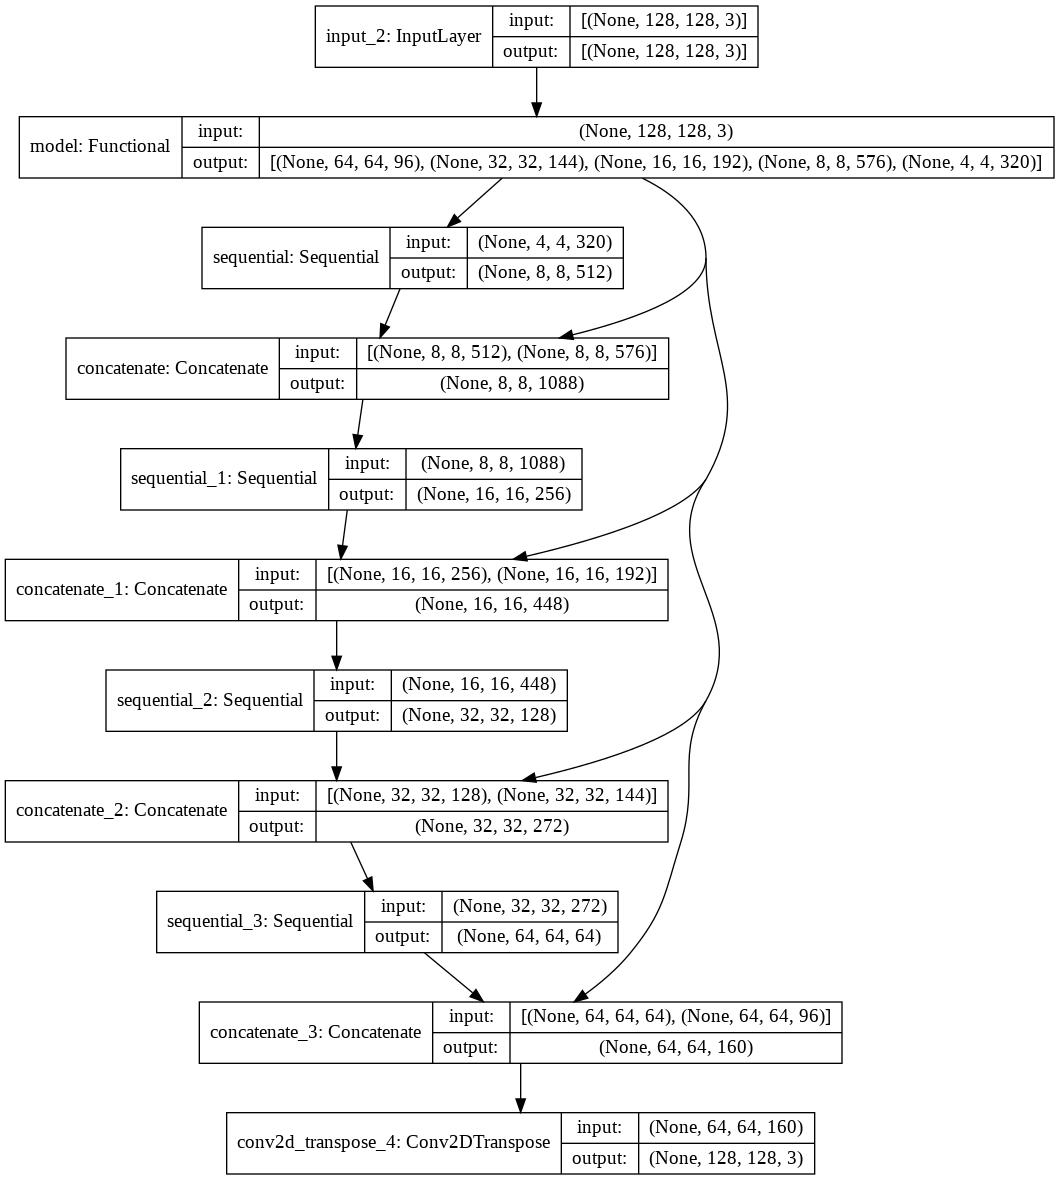

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

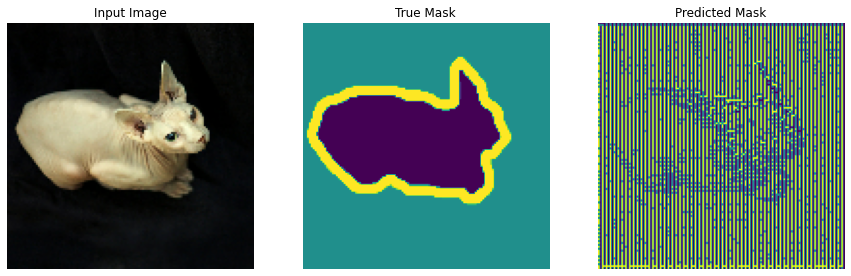

In [ ]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

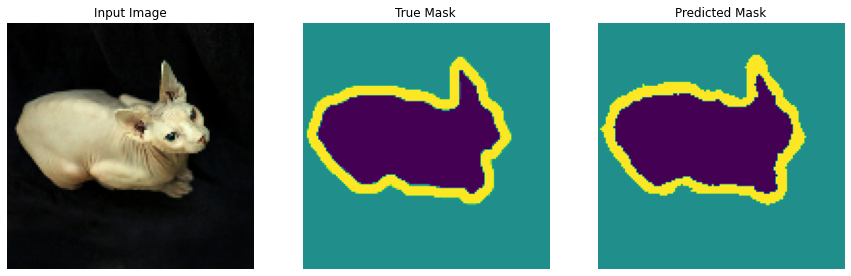


Sample Prediction after epoch 20



In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

One good thing to check is the evolution of the metrics along the training

## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

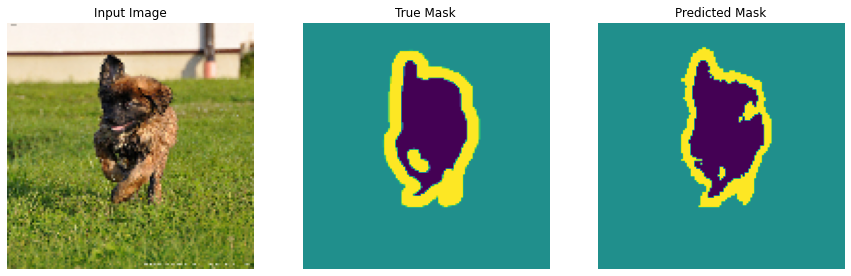

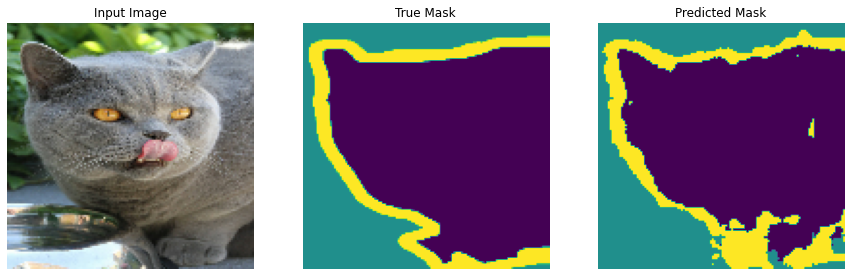

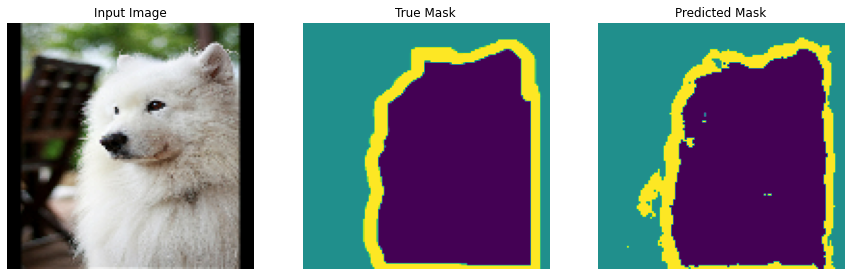

In [ ]:
show_predictions(test_dataset, 3)

## Next steps

Now that you have a first model running for this task, you can try out with different intermediate layer outputs, or different pretrained model, and even other models architecture well suited for image segmentation (see presentation of state-of-the-art models [here](https://neptune.ai/blog/image-segmentation-in-2020))

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) for another model you can retrain on your own data.